In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.stattools import durbin_watson
from tqdm import tqdm
from xgboost import XGBRegressor

# Comparison of Decision Tree Models for California Housing Dataset

In [ ]:
# 1. Load Data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Initialize Models
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=10, learning_rate=0.1),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.1, verbosity=0),
}

# 3. Train and Evaluate
results = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    _train_t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - _train_t0
    _predict_t0 = time.perf_counter()
    preds = model.predict(X_test)
    predict_time = time.perf_counter() - _predict_t0
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {
        "RMSE": np.sqrt(mse),
        "R2": r2,
        "Train Time": train_time,
        "Predict Time": predict_time,
    }

# Display Results
print(pd.DataFrame(results).T)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

Training Models: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                       RMSE        R2  Train Time  Predict Time
Decision Tree      0.724234  0.599732    0.080096      0.001280
Random Forest      0.533125  0.783104    1.262091      0.015455
Gradient Boosting  0.808273  0.501449    0.479101      0.002252
XGBoost            0.450263  0.845288    1.612081      0.025381


# EDA

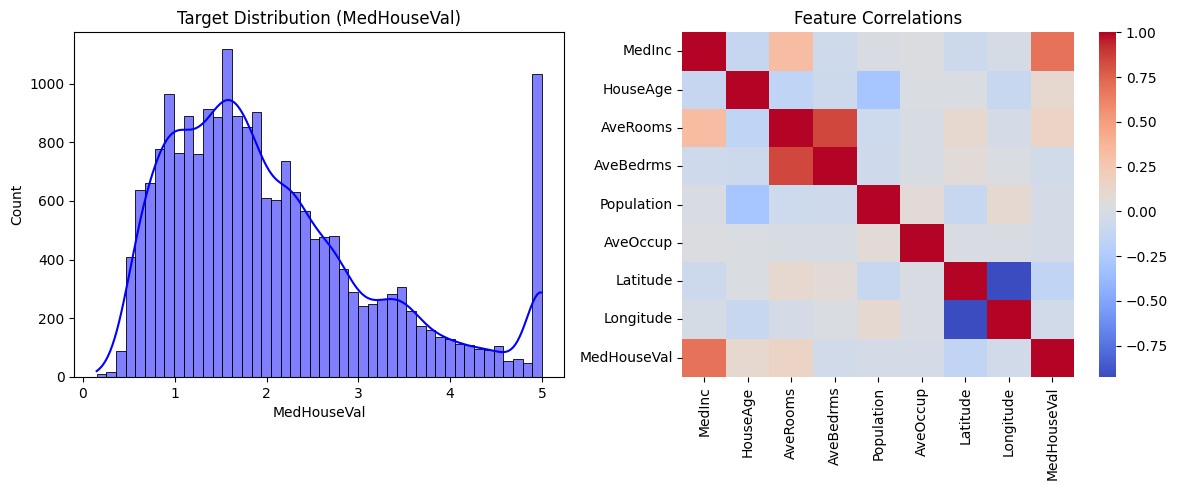

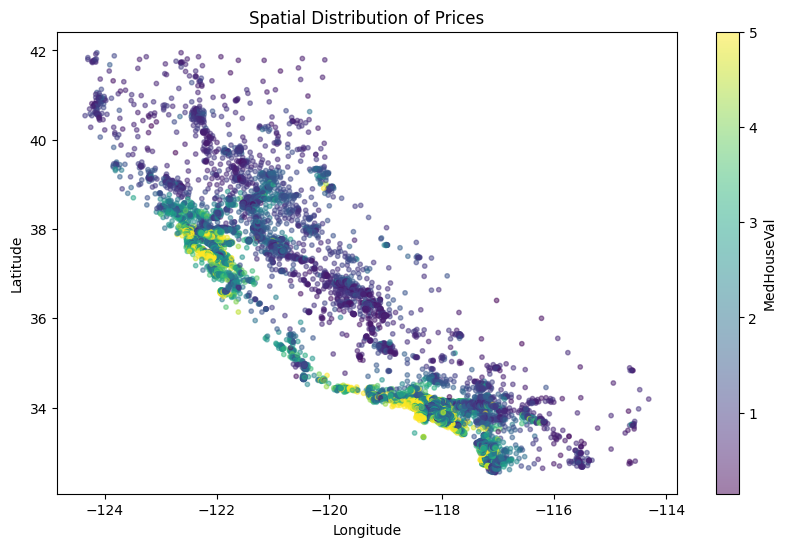

In [ ]:
# Load and prepare
cal_data = fetch_california_housing()
df = pd.DataFrame(cal_data.data, columns=cal_data.feature_names)
df["MedHouseVal"] = cal_data.target

# 1. Distribution Check
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["MedHouseVal"], kde=True, color="blue")
plt.title("Target Distribution (MedHouseVal)")

# 2. Correlation Matrix
plt.subplot(1, 2, 2)
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlations")
plt.tight_layout()
plt.show()

# 3. Geometric EDA (Critical for this dataset)
plt.figure(figsize=(10, 6))
plt.scatter(
    df["Longitude"],
    df["Latitude"],
    c=df["MedHouseVal"],
    cmap="viridis",
    alpha=0.5,
    s=10,
)
plt.colorbar(label="MedHouseVal")
plt.title("Spatial Distribution of Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

--- Mutual Information Scores ---
DistToHub          0.428726
Longitude          0.400015
MedInc             0.387584
Latitude           0.369811
Cluster            0.227507
RoomsPerPerson     0.180310
BedroomsPerRoom    0.141894
AveRooms           0.103260
AveOccup           0.072458
HouseAge           0.029278
AveBedrms          0.023935
Population         0.020707
dtype: float64


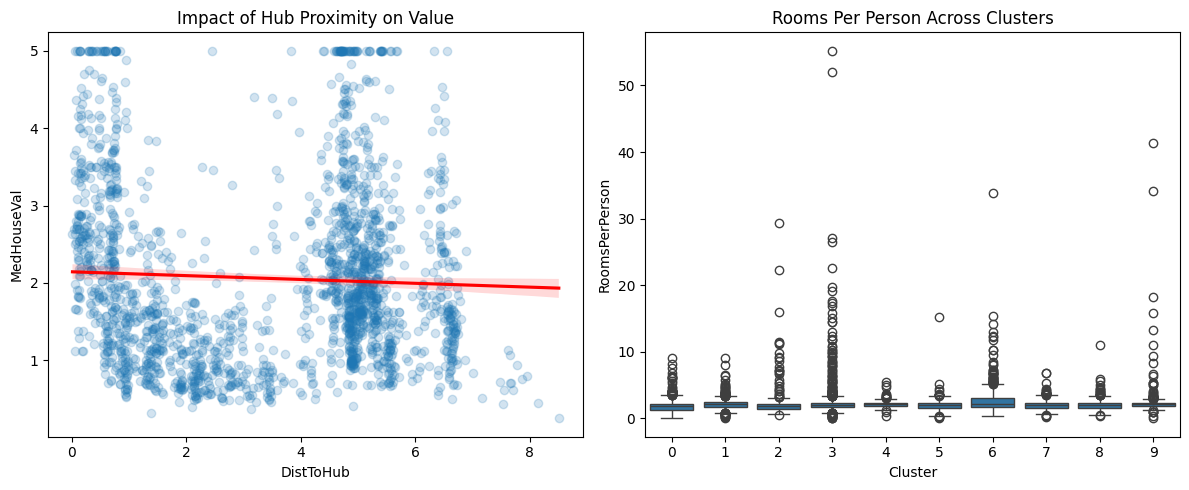

In [ ]:
# Load Data
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["MedHouseVal"] = data.target

# --- Feature Engineering ---

# 1. Household Dynamics (Ratios)
df["RoomsPerPerson"] = df["AveRooms"] / df["AveOccup"]
df["BedroomsPerRoom"] = df["AveBedrms"] / df["AveRooms"]

# 2. Spatial Clustering (Neighborhoods)
# This captures "hotspots" that Latitude/Longitude alone might take longer to learn
coords = df[["Latitude", "Longitude"]]
kmeans = KMeans(n_clusters=10, random_state=0)
df["Cluster"] = kmeans.fit_predict(coords)

# 3. Distance to "Expensive" Hubs
# We define a proxy for a hub: the center of the most expensive cluster
hub_coords = df.groupby("Cluster")["MedHouseVal"].mean().idxmax()
hub_lat, hub_lon = kmeans.cluster_centers_[hub_coords]
df["DistToHub"] = np.sqrt(
    (df["Latitude"] - hub_lat) ** 2 + (df["Longitude"] - hub_lon) ** 2
)

# Define feature sets for comparison
original_features = data.feature_names
new_features = ["RoomsPerPerson", "BedroomsPerRoom", "Cluster", "DistToHub"]


# Calculate MI for all features
mi_scores = mutual_info_regression(df.drop("MedHouseVal", axis=1), df["MedHouseVal"])
mi_results = pd.Series(
    mi_scores, index=df.drop("MedHouseVal", axis=1).columns
).sort_values(ascending=False)

print("--- Mutual Information Scores ---")
print(mi_results)

plt.figure(figsize=(12, 5))

# Plot 1: Distance to Hub vs Price
plt.subplot(1, 2, 1)
sns.regplot(
    data=df.sample(2000),
    x="DistToHub",
    y="MedHouseVal",
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "red"},
)
plt.title("Impact of Hub Proximity on Value")

# Plot 2: Rooms Per Person Distribution by Cluster
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x="Cluster", y="RoomsPerPerson")
plt.title("Rooms Per Person Across Clusters")

plt.tight_layout()
plt.show()

# CV Experiment

In [ ]:
# Define Cross-Validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)


def evaluate_set(X_data, y_data, name):
    model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, n_jobs=-1)

    scores = cross_validate(
        model,
        X_data,
        y_data,
        cv=cv,
        scoring=["r2", "neg_mean_absolute_error"],
        return_train_score=True,
    )

    print(f"\n--- {name} Results ---")
    print(
        f"Test R2:  {scores['test_r2'].mean():.4f} (+/- {scores['test_r2'].std():.4f})"
    )
    print(f"Test MAE: {-scores['test_neg_mean_absolute_error'].mean():.4f}")
    print(f"Train R2: {scores['train_r2'].mean():.4f} (Bias/Variance Check)")


# Evaluate Both
evaluate_set(df[original_features], df["MedHouseVal"], "Original Dataset")
evaluate_set(df.drop("MedHouseVal", axis=1), df["MedHouseVal"], "Engineered Dataset")


--- Original Dataset Results ---
Test R2:  0.8458 (+/- 0.0082)
Test MAE: 0.2958
Train R2: 0.9391 (Bias/Variance Check)

--- Engineered Dataset Results ---
Test R2:  0.8528 (+/- 0.0066)
Test MAE: 0.2867
Train R2: 0.9450 (Bias/Variance Check)


# Optuna Hyperparameter Tuning

In [ ]:
#  1. Load and Prepare Data
data = fetch_california_housing()
df_orig = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Original Feature Set
X_orig = df_orig.copy()

# Feature Engineering
X_eng = df_orig.copy()
X_eng["RoomsPerPerson"] = X_eng["AveRooms"] / X_eng["AveOccup"]
X_eng["BedroomsPerRoom"] = X_eng["AveBedrms"] / X_eng["AveRooms"]

# Spatial Clustering
coords = X_eng[["Latitude", "Longitude"]]
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
X_eng["Cluster"] = kmeans.fit_predict(coords)

# Distance to Hub
hub_idx = pd.Series(y).groupby(X_eng["Cluster"]).mean().idxmax()
hub_lat, hub_lon = kmeans.cluster_centers_[hub_idx]
X_eng["DistToHub"] = np.sqrt(
    (X_eng["Latitude"] - hub_lat) ** 2 + (X_eng["Longitude"] - hub_lon) ** 2
)


# 2. Optuna Objective Function
def objective(trial, X, y_data):
    params = {
        "n_estimators": 500,  # Reduced for faster execution in sandbox
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
        "n_jobs": -1,
        "tree_method": "hist",
    }
    model = xgb.XGBRegressor(**params)
    # Using 3-fold for optimization speed
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_validate(model, X, y_data, cv=cv, scoring="r2", n_jobs=-1)
    return score["test_score"].mean()


# 3. Tuning Original Dataset
print("Tuning Original Dataset...")
study_orig = optuna.create_study(direction="maximize")
study_orig.optimize(lambda trial: objective(trial, X_orig, y), n_trials=10)

# 4. Tuning Engineered Dataset
print("Tuning Engineered Dataset...")
study_eng = optuna.create_study(direction="maximize")
study_eng.optimize(lambda trial: objective(trial, X_eng, y), n_trials=10)

# 5. Final Evaluation with Best Params
cv_final = KFold(n_splits=5, shuffle=True, random_state=42)


def final_eval(X, y_data, params, label):
    model = xgb.XGBRegressor(
        **params, n_estimators=1000
    )  # Beef up estimators for final eval
    results = cross_validate(
        model,
        X,
        y_data,
        cv=cv_final,
        scoring=["r2", "neg_mean_absolute_error"],
        return_train_score=True,
        n_jobs=-1,
    )
    return {
        "Label": label,
        "Test R2": results["test_r2"].mean(),
        "Test R2 Std": results["test_r2"].std(),
        "Test MAE": -results["test_neg_mean_absolute_error"].mean(),
        "Train R2": results["train_r2"].mean(),
    }


res_orig = final_eval(X_orig, y, study_orig.best_params, "Original")
res_eng = final_eval(X_eng, y, study_eng.best_params, "Engineered")

comparison_df = pd.DataFrame([res_orig, res_eng])
print("\n--- Comparison Results ---")
print(comparison_df)

print("\n--- Best Params Original ---")
print(study_orig.best_params)
print("\n--- Best Params Engineered ---")
print(study_eng.best_params)

[I 2026-02-11 06:19:17,843] A new study created in memory with name: no-name-566bc19e-7428-4599-ac11-353f128038a0


Tuning Original Dataset...


[I 2026-02-11 06:19:23,095] Trial 0 finished with value: 0.8441112402692728 and parameters: {'learning_rate': 0.08415937905371375, 'max_depth': 10, 'subsample': 0.6686254843241554, 'colsample_bytree': 0.8813998690279921, 'reg_lambda': 5.236159634030279, 'reg_alpha': 0.058198512067185834}. Best is trial 0 with value: 0.8441112402692728.
[I 2026-02-11 06:19:23,603] Trial 1 finished with value: 0.8205944831841451 and parameters: {'learning_rate': 0.06422577597647253, 'max_depth': 3, 'subsample': 0.6405024320804579, 'colsample_bytree': 0.7002034581689198, 'reg_lambda': 0.21867786919065454, 'reg_alpha': 0.07270108745703222}. Best is trial 0 with value: 0.8441112402692728.
[I 2026-02-11 06:19:25,413] Trial 2 finished with value: 0.8467046192564762 and parameters: {'learning_rate': 0.12494943420601234, 'max_depth': 8, 'subsample': 0.7014481937351212, 'colsample_bytree': 0.6670277443378816, 'reg_lambda': 2.3055333393538713, 'reg_alpha': 0.34212964296018084}. Best is trial 2 with value: 0.84670

Tuning Engineered Dataset...


[I 2026-02-11 06:19:40,226] Trial 0 finished with value: 0.851051640848564 and parameters: {'learning_rate': 0.15557105031342433, 'max_depth': 10, 'subsample': 0.911352149358804, 'colsample_bytree': 0.6191082264757723, 'reg_lambda': 7.85655888595644, 'reg_alpha': 0.12234556912591561}. Best is trial 0 with value: 0.851051640848564.
[I 2026-02-11 06:19:40,908] Trial 1 finished with value: 0.7951363946846494 and parameters: {'learning_rate': 0.010536325518230727, 'max_depth': 4, 'subsample': 0.6959145658926736, 'colsample_bytree': 0.6101915828987284, 'reg_lambda': 0.1794768123240817, 'reg_alpha': 0.07948251551872437}. Best is trial 0 with value: 0.851051640848564.
[I 2026-02-11 06:19:41,792] Trial 2 finished with value: 0.8184293196147943 and parameters: {'learning_rate': 0.011615327807251202, 'max_depth': 5, 'subsample': 0.9145971215495936, 'colsample_bytree': 0.7299036739495826, 'reg_lambda': 0.03084977887816636, 'reg_alpha': 0.8824120175470899}. Best is trial 0 with value: 0.8510516408


--- Comparison Results ---
        Label   Test R2  Test R2 Std  Test MAE  Train R2
0    Original  0.854890     0.006975  0.283039  0.985729
1  Engineered  0.859817     0.006758  0.277505  0.964354

--- Best Params Original ---
{'learning_rate': 0.041147565191984994, 'max_depth': 8, 'subsample': 0.8712727666572129, 'colsample_bytree': 0.9744508343597771, 'reg_lambda': 1.0204709826243563, 'reg_alpha': 1.249783846570182}

--- Best Params Engineered ---
{'learning_rate': 0.0470778569460603, 'max_depth': 8, 'subsample': 0.964350612603772, 'colsample_bytree': 0.830341351680294, 'reg_lambda': 0.6689706037887645, 'reg_alpha': 5.186332191428168}


# Train Final Model with Best Hyperparameters

In [ ]:
# 1. Train final model with your Optuna best params
best_params = study_eng.best_params
model = xgb.XGBRegressor(**best_params, n_estimators=1000)
model.fit(X_eng, y)

# Get predictions for residual analysis
y_pred = model.predict(X_eng)
residuals = y - y_pred

# Model Evaluation and Residual Analysis

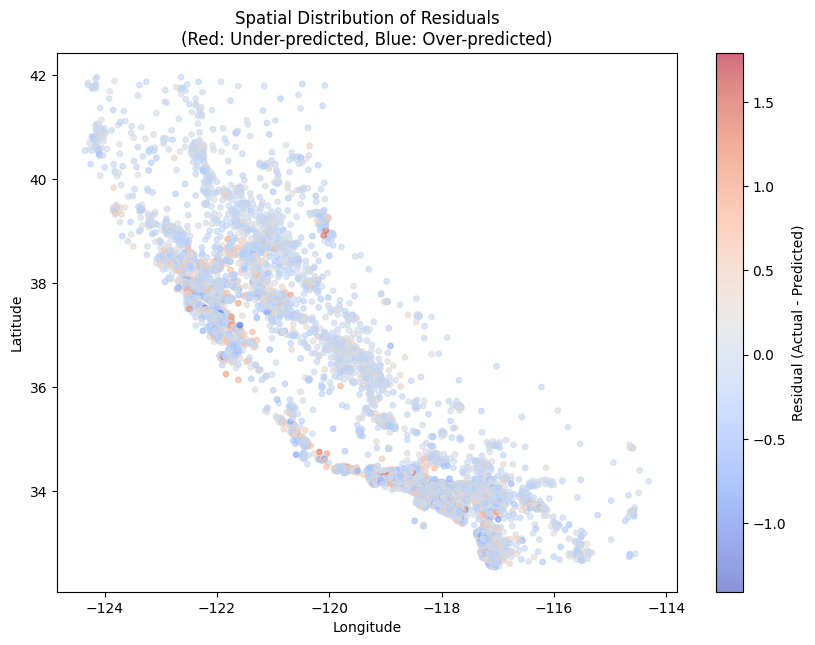

In [ ]:
dw_score = durbin_watson(residuals)
print(f"Durbin-Watson score: {dw_score:.4f}")

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_eng["Longitude"], X_eng["Latitude"], c=residuals, cmap="coolwarm", alpha=0.6, s=15
)
plt.colorbar(sc, label="Residual (Actual - Predicted)")
plt.title(
    "Spatial Distribution of Residuals\n(Red: Under-predicted, Blue: Over-predicted)"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

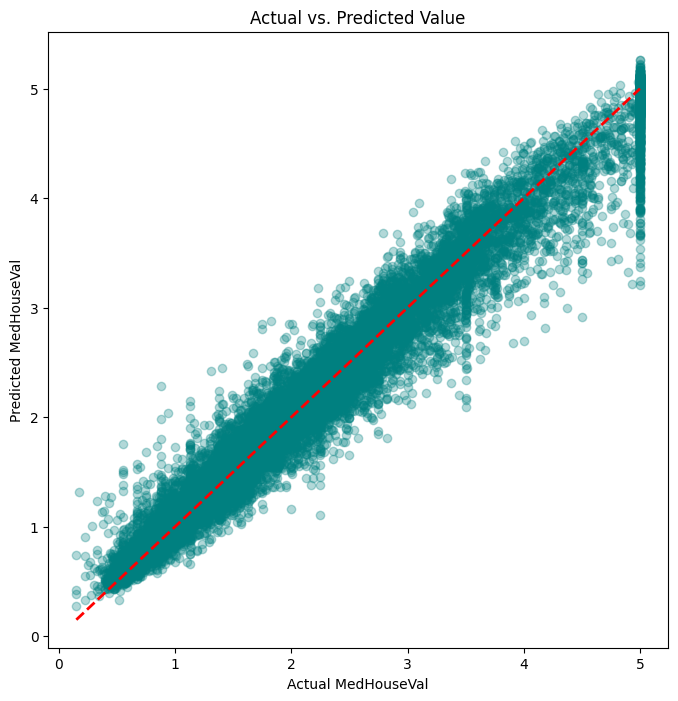

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3, color="teal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)  # Perfect prediction line
plt.xlabel("Actual MedHouseVal")
plt.ylabel("Predicted MedHouseVal")
plt.title("Actual vs. Predicted Value")
plt.show()

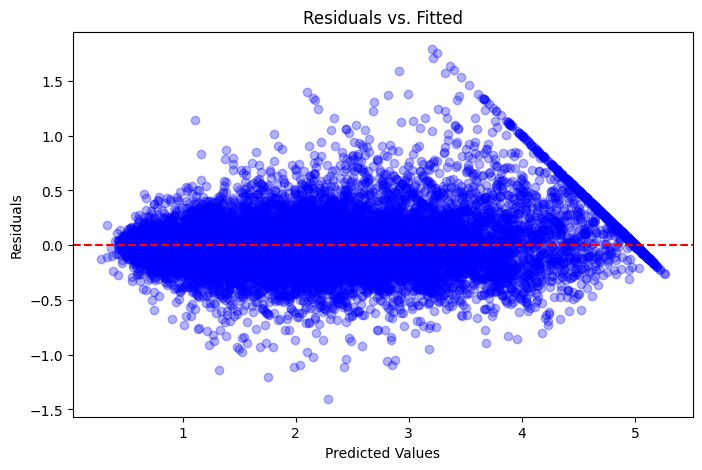

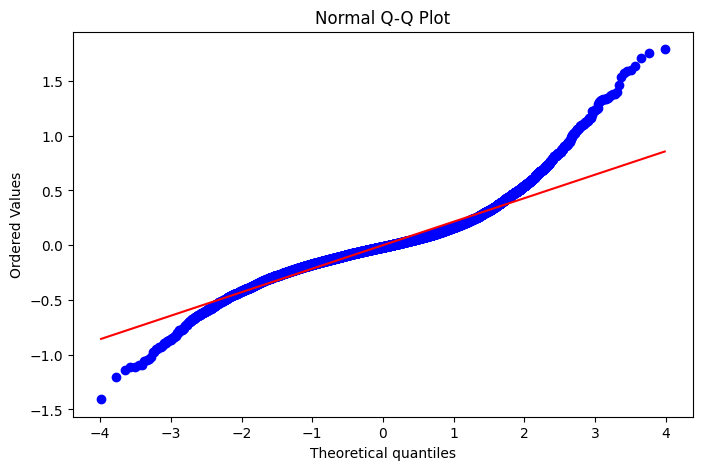

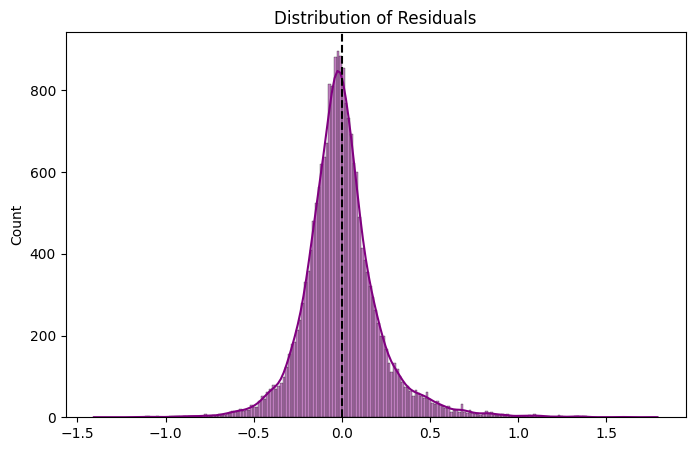

In [ ]:
y_pred = model.predict(X_eng)
residuals = y - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.3, color="blue")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()


plt.figure(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color="purple")
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution of Residuals")
plt.show()